# Sparse CNN: MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [ ]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings("ignore")    #category=DeprecationWarning, message='is a deprecated alias'

useSparseCNN = True
if(useSparseCNN):
    #set Runtime type = high RAM
    batchSize = 128 #max value determined by numberOfSparseConvolutionLayers, numberOfchannelsFirstDenseLayer, GPU RAM
else:
    batchSize = 128

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [ ]:
mnist = fetch_openml('mnist_784', cache=False)

In [ ]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

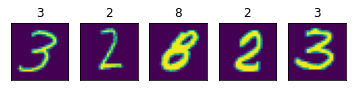

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
    batch_size=batchSize,
)

In [ ]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8338       0.8873        0.3970  1.1072
      2        0.4317       0.9103        0.3152  1.1979
      3        0.3663       0.9191        0.2756  1.1457
      4        0.3213       0.9332        0.2321  1.3256
      5        0.2916       0.9371        0.2106  1.6596
      6        0.2727       0.9430        0.1965  1.7328
      7        0.2591       0.9458        0.1859  1.8585
      8        0.2440       0.9489        0.1767  1.9051
      9        0.2311       0.9497        0.1708  1.6888
     10        0.2230       0.9551        0.1581  1.3889
     11        0.2157       0.9558        0.1538  1.0519
     12        0.2038       0.9569        0.1472  1.0869
     13        0.2006       0.9567        0.1449  1.1013
     14        0.1962       0.9586        0.1404  1.0845
     15        0.1914       0.9591        0.1391  1.1113
     16        0.1845       0.9

## Prediction

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = net.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9625142857142858

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [ ]:
error_mask = y_pred != y_test

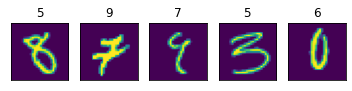

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

In [ ]:
XCnn = X.reshape(-1, 1, 28, 28)

In [ ]:
XCnn.shape

(70000, 1, 28, 28)

In [ ]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [ ]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [ ]:


class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()

        height = 28 #MNIST defined
        width = 28  #MNIST defined
        kernelSize = 3
        padding = 0
        stride = 1
        self.maxPoolSize = 2 #assume max pool at each layer

        self.numberOfSparseConvolutionLayers = 1 #default: 1 (1 or 2)
        if(self.numberOfSparseConvolutionLayers == 1):
            self.numberOfchannelsFirstDenseLayer = 32   #first/dense CNN layer
        elif(self.numberOfSparseConvolutionLayers == 2):
            self.numberOfchannelsFirstDenseLayer = 8    #first/dense CNN layer 
        else:
            print("useSparseCNN warning: numberOfSparseConvolutionLayers is too high for compute/memory")
            self.numberOfchannelsFirstDenseLayer = 2

        numberOfchannels = self.numberOfchannelsFirstDenseLayer  
        self.conv1 = nn.Conv2d(1, numberOfchannels, kernel_size=kernelSize, padding=padding, stride=stride)
        height, width = self.getImageDimensionsAfterConv(height, width, kernelSize, padding, stride, self.maxPoolSize)

        self.sparseConvList = [None]*self.numberOfSparseConvolutionLayers
        for c in range(self.numberOfSparseConvolutionLayers):
            #print("c = ", c)
            if(useSparseCNN):
                numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
                #print("numberOfchannels = ", numberOfchannels)
                #print("numChannelPairs = ", numChannelPairs)
                self.sparseConvList[c] = []
                numberOfInputChannels = 2
                numberOfOutputChannels = 1
                for channelPairIndex in range(numChannelPairs):
                    conv2 = nn.Conv2d(numberOfInputChannels, numberOfOutputChannels, kernel_size=kernelSize, padding=padding, stride=stride)
                    self.sparseConvList[c].append(conv2)
                height, width = self.getImageDimensionsAfterConv(height, width, kernelSize, padding, stride, self.maxPoolSize)
                numberOfchannels = numChannelPairs*numberOfOutputChannels
            else:
                numberOfInputChannels = numberOfchannels
                numberOfOutputChannels = numberOfchannels*2
                conv2 = nn.Conv2d(numberOfchannels, numberOfOutputChannels, kernel_size=kernelSize, padding=padding, stride=stride)
                height, width = self.getImageDimensionsAfterConv(height, width, kernelSize, padding, stride, self.maxPoolSize)
                self.sparseConvList[c] = conv2
                numberOfchannels = numberOfOutputChannels

        firstLinearInputSize = numberOfchannels*width*height

        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(firstLinearInputSize, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), kernel_size=self.maxPoolSize))
        numberOfchannels = self.numberOfchannelsFirstDenseLayer

        for c in range(self.numberOfSparseConvolutionLayers):
            if(useSparseCNN):
                numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
                channelsPairsList = self.convertToChannelsToChannelPairsList(x)
                channelPairCNNoutputList = []
                numberOfInputChannels = 2
                numberOfOutputChannels = 1
                for channelPairIndex in range(numChannelPairs):
                    CNNin = channelsPairsList[channelPairIndex]
                    CNNout = (self.sparseConvList[c])[channelPairIndex](CNNin)
                    CNNout = torch.squeeze(CNNout, dim=1)   #remove channel dim (size=numberOfOutputChannels=1); prepare for convertChannelPairCNNoutputListToChannels execution
                    channelPairCNNoutputList.append(CNNout)
                CNNout = self.convertChannelPairCNNoutputListToChannels(channelPairCNNoutputList)
                numberOfchannels = numChannelPairs*numberOfOutputChannels
            else:
                CNNin = x
                CNNout = (self.sparseConvList[c])(CNNin)
            CNNout = torch.relu(F.max_pool2d(self.conv2_drop(CNNout), kernel_size=self.maxPoolSize))
            x = CNNout

        # flatten over channel, height and width
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

    def getImageDimensionsAfterConv(self, inputHeight, inputWidth, kernelSize, padding, stride, maxPoolSize):
        height = (inputHeight - (kernelSize//2 * 2) + padding) // stride // maxPoolSize    #// = integer floor division
        width = (inputWidth - (kernelSize//2 * 2) + padding) // stride // maxPoolSize
        return height, width

    def calculateNumberChannelPairs(self, numInputChannels):
        numChannelPairs = numInputChannels**2
        return numChannelPairs
        #numOutputChannels = number of filters

    def convertToChannelsToChannelPairsList(self, channels):
        batchSize, numberOfchannels, height, width = self.getCNNtensorProperties(channels)
        numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
        channelsPairsList = []
        for channelIndex1 in range(numberOfchannels):
            for channelIndex2 in range(numberOfchannels):
                channelPairIndex = channelIndex1*numChannelPairs + channelIndex2
                channelPairSub1 = channels[:, channelIndex1, :, :] 
                channelPairSub2 = channels[:, channelIndex2, :, :]
                channelPairSub1 = torch.unsqueeze(channelPairSub1, dim=1)
                channelPairSub2 = torch.unsqueeze(channelPairSub2, dim=1)
                channelPair = torch.cat((channelPairSub1, channelPairSub2), dim=1)
                channelsPairsList.append(channelPair)
        return channelsPairsList
    
    def getCNNtensorProperties(self, channels):
        batchSize = channels.shape[0]
        numberOfchannels = channels.shape[1]
        height = channels.shape[2]
        width = channels.shape[3]
        return batchSize, numberOfchannels, height, width

    def convertChannelPairCNNoutputListToChannels(self, channelPairCNNoutputList):
        channels = torch.stack(channelPairCNNoutputList, dim=1)
        return channels
     

In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
    batch_size=batchSize,
)

In [36]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss        dur
-------  ------------  -----------  ------------  ---------
      1        1.2500       0.9435        0.3034  1905.1023
      2        0.7788       0.9609        0.1745  1872.1424
      3        0.7021       0.9672        0.1217  1880.2002
      4        0.6693       0.9653        0.1244  1877.6903
      5        0.6527       0.9704        0.1165  1872.7935
      6        0.6322       0.9706        0.1132  1869.6956
      7        0.6165       0.9743        0.0971  1886.2437
      8        0.6090       0.9740        0.0984  1945.4915
      9        0.5972       0.9767        0.0895  1946.0111
     10        0.5935       0.9722        0.1019  1948.7684


In [37]:
y_pred_cnn = cnn.predict(XCnn_test)

In [40]:
accuracy_score(y_test, y_pred_cnn)

0.9712

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [47]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.5615835777126099

Over 70% of the previously misclassified images are now correctly identified.

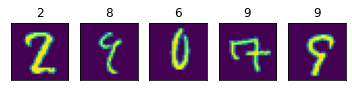

In [48]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])